In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
# file with velocities
rawVelFileName = "../data/test-vels-north.txt"
# need to format the file appropritely, before we can read it
outFormattedFile = "../data/formatted-vels.txt"
# os.system( 'cat ' + rawVelFileName + ' | tr -s "  " > ' + outFormattedFile )
inpColNames = [ "dateStr", "timeStr", "beam", "range", \
          "azim", "Vlos", "MLAT", "MLON", "MLT", "radId", \
          "radCode"]
velsDataDF = pandas.read_csv(outFormattedFile, sep=' ',\
                             header=None, names=inpColNames)
# add a datetime col
velsDataDF["date"] = pandas.to_datetime( \
                        velsDataDF['dateStr'].astype(str) + "-" +\
                        velsDataDF['timeStr'].astype(str), format='%Y%m%d-%H%M')
# for some reason MLAT is a str type, convert it to float
velsDataDF["MLAT"] = velsDataDF["MLAT"].astype(float)
# Also get a normMLT for plotting
velsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in velsDataDF['MLT']]
velsDataDF.head()
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,600,0,26,-60.95,-2.2716,53.2044,-21.8611,23.6993,33,bks,2011-04-09 06:00:00,-0.3007
1,20110409,600,0,27,-60.95,-5.1056,53.3065,-22.5771,23.6515,33,bks,2011-04-09 06:00:00,-0.3485
2,20110409,600,0,28,-60.95,-5.1056,53.4035,-23.2954,23.6036,33,bks,2011-04-09 06:00:00,-0.3964
3,20110409,600,0,29,-60.95,-4.5666,53.4954,-24.0159,23.5556,33,bks,2011-04-09 06:00:00,-0.4444
4,20110409,600,0,30,-60.95,-3.6944,53.5823,-24.7384,23.5074,33,bks,2011-04-09 06:00:00,-0.4926


In [3]:
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
# remove velocies whose magnitude is less than 200 m/s
velsDataDF = velsDataDF[ abs(velsDataDF["Vlos"]) >= 200. ]
# SAPS(westward) Vlos are positive for positive azimuths and vice versa.
# filter the others out
velsDataDF = velsDataDF[ velsDataDF["azim"]/velsDataDF["Vlos"] > 0. ].reset_index(drop=True)
velsDataDF.head()
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,706,9,28,-26.21,-244.3651,59.1492,-14.0168,1.3205,33,bks,2011-04-09 07:06:00,1.3205
1,20110409,706,10,28,-22.35,-244.3651,59.5371,-12.4132,1.4274,33,bks,2011-04-09 07:06:00,1.4274
2,20110409,708,9,27,-26.21,-226.6634,58.8263,-13.5483,1.3848,33,bks,2011-04-09 07:08:00,1.3848
3,20110409,708,10,27,-22.35,-226.6634,59.1965,-12.0037,1.4878,33,bks,2011-04-09 07:08:00,1.4878
4,20110409,730,8,27,-30.07,-257.8685,58.3937,-14.9997,1.6560,33,bks,2011-04-09 07:30:00,1.6560


In [4]:
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
datFileName = "../data/processedSaps.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ', dtype={'dateStr':'str', 'time': 'str'})

sapsDataDF["date"] = pandas.to_datetime( \
                        sapsDataDF['dateStr'] + "-" +\
                        sapsDataDF['time'], format='%Y%m%d-%H%M')
sapsDataDF.head()
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####

,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time,date
0,20110107,56.5,17.7543,308.2077,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
1,20110107,55.5,18.0147,224.1588,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
2,20110107,56.5,17.8749,307.4328,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
3,20110107,55.5,18.1324,222.4787,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
4,20110107,56.5,17.9955,305.4201,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07


In [5]:
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
# we choose 0840 UT since that time was analyzed in the paper
timeSlctd = datetime.datetime( 2011, 4, 9, 8, 40 )
velAnlysDF = velsDataDF[ velsDataDF["date"] == timeSlctd ].reset_index(drop=True)
sapsSelPrdDF = sapsDataDF[  ( sapsDataDF["date"] - timeSlctd < numpy.timedelta64(30,'m') )\
           & ( sapsDataDF["date"] - timeSlctd > numpy.timedelta64(0,'m') )  ].reset_index(drop=True)
# Now check if there is more than one time period in the selected interval
# ideally there shouldn't be, but if we find one we should do something
# about it (like take an average)...for now its undecided.!
if len( sapsSelPrdDF["time"].unique() ) > 1:
    print "There is more than one time period selected!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
poesBndDF = sapsSelPrdDF[ ["poesMLT", "poesLat"] \
                    ].drop_duplicates().reset_index(drop=True)
# Have a normalized MLT for ease of comparison
poesBndDF['normMLT'] = [x-24 if x >= 12 else x for x in poesBndDF['poesMLT']]
poesBndDF.head()
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####

,poesMLT,poesLat,normMLT
0,0,62.0360,0
1,1,61.5064,1
2,2,61.2108,2
3,3,61.1692,3
4,23,62.7634,-1


In [6]:
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
# Merge POES boundary DF with the vels DF
velAnlysDF["normMLTRound"] = velAnlysDF["normMLT"].astype(int)
print "shape before join--->", velAnlysDF.shape
velAnlysDF = pandas.merge( velAnlysDF, poesBndDF, left_on="normMLTRound", right_on="normMLT", how="inner" )
print "shape after join--->", velAnlysDF.shape
# Filter out velocties above the POES boundary
velAnlysDF = velAnlysDF[ velAnlysDF["MLAT"] < velAnlysDF["poesLat"]\
                       ].reset_index(drop=True).drop_duplicates()
print "shape after filtering by boundary--->", velAnlysDF.shape
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####

shape before join---> (204, 14)
shape after join---> (195, 17)
shape after filtering by boundary---> (195, 17)


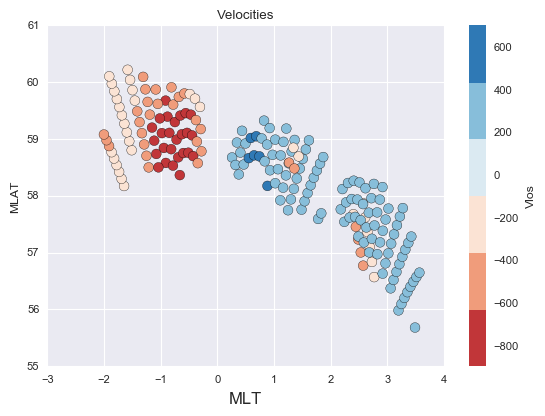

In [7]:
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
velAnlysDF.plot( kind='scatter',
              x='normMLT_x',
              y='MLAT',
              c='Vlos',
              s=50., cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
# ax.set_ylim( [55., 62.] )

# ax.get_figure().savefig("../figs/sapsVels.pdf",bbox_inches='tight')
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####
#### Plot the chosen SAPS velocities ####

In [8]:
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
# make a grid which is 0.5 in MLT and 0.25 in MLAT
gridSizeMLT = 0.5
gridsizeMLAT = 0.25
velAnlysDF["grid_MLT"] = [ round(x*gridSizeMLT**-1)/(gridSizeMLT**-1) for x in velAnlysDF['normMLT_x'] ]
velAnlysDF["grid_MLAT"] = [ round(x*gridsizeMLAT**-1)/(gridsizeMLAT**-1) for x in velAnlysDF['MLAT'] ]
velAnlysDF = velAnlysDF[ [ "beam", "range", "azim", "Vlos", "MLAT", \
                          "MLT", "grid_MLT", "grid_MLAT", "radId", \
                          "radCode", "normMLT_x" ] ]
velAnlysDF.head()
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####

,beam,range,azim,Vlos,MLAT,MLT,grid_MLT,grid_MLAT,radId,radCode,normMLT_x
0,5,27,-41.65,-378.1679,56.7707,2.5742,2.5,56.75,33,bks,2.5742
1,5,28,-41.65,-396.3842,57.0027,2.5315,2.5,57.00,33,bks,2.5315
2,5,29,-41.65,-379.2044,57.2309,2.4884,2.5,57.25,33,bks,2.4884
3,5,30,-41.65,-368.0763,57.4553,2.4448,2.5,57.50,33,bks,2.4448
4,5,31,-41.65,-321.3911,57.6758,2.4007,2.5,57.75,33,bks,2.4007


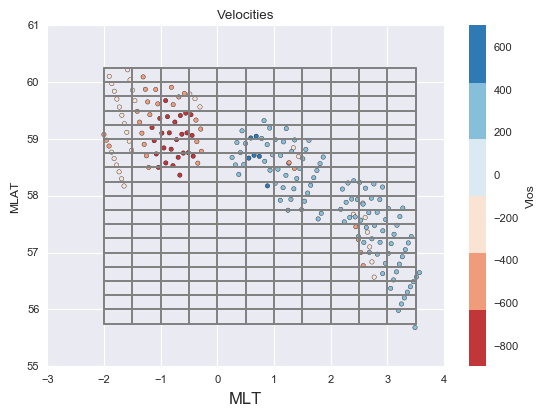

In [9]:
# print velAnlysDF[ velAnlysDF["radCode"] == "cve" ]#.plot( x="azim", y="Vlos", kind="scatter" )
#### Plot the chosen SAPS velocities on the grid ####
#### Plot the chosen SAPS velocities on the grid ####
#### Plot the chosen SAPS velocities on the grid ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
plotMLTs = velAnlysDF['grid_MLT'].unique().tolist()
plotMLATs = velAnlysDF['grid_MLAT'].unique().tolist()
for currMLT in plotMLTs :
    ax.plot( [currMLT, currMLT], [ min(plotMLATs), max(plotMLATs) ], '0.5' )
ax.plot( [0., 0.], [ min(plotMLATs), max(plotMLATs) ], '0.5' )
for currMLAT in plotMLATs :
    ax.plot( [ min(plotMLTs), max(plotMLTs) ], [currMLAT, currMLAT], '0.5' )
velAnlysDF.plot( kind='scatter',
              x='normMLT_x',
              y='MLAT',
              c='Vlos',
              s=10., cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
ax.set_ylim( [int(round(velAnlysDF['grid_MLAT'].min()))-1, \
              int(round(velAnlysDF['grid_MLAT'].max()))+1] )
ax.set_xlim( [int(round(velAnlysDF['grid_MLT'].min()))-1, \
              int(round(velAnlysDF['grid_MLT'].max()))] )

ax.get_figure().savefig("../figs/sapsVels-smallgrid.pdf",bbox_inches='tight')
#### Plot the chosen SAPS velocities on the grid ####
#### Plot the chosen SAPS velocities on the grid ####
#### Plot the chosen SAPS velocities on the grid ####

In [10]:
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####

In [63]:
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####
# get count of data points in each cell
gridCounts = velAnlysDF.groupby(["grid_MLT", "grid_MLAT"])["Vlos"].count()
# Get max and min azim values
azimMax = velAnlysDF.groupby(["grid_MLT", "grid_MLAT"], sort=False)\
             ['azim'].max()
azimMin = velAnlysDF.groupby(["grid_MLT", "grid_MLAT"], sort=False)\
             ['azim'].min()
azimMax.name = 'max_azim'
azimMin.name = 'min_azim'
gridCounts.name = 'count'
gridDataDF = pandas.concat( [azimMax, azimMin, gridCounts], axis=1 ).reset_index()
# We'll store the fitting results in a DF
gridMLTArr = []
gridMLATArr = []
gridMLTEndArr = []
gridMLATEndArr = []
vMaxArr = []
azimArr = []
vErrArr = []
azimErrArr = []
vLosMeanArr = []
vLosMaxArr = []
fitDiscardArr = []

normMltVals = list( numpy.sort( gridDataDF["grid_MLT"].unique() ) )
mlatVals = list( numpy.sort( gridDataDF["grid_MLAT"].unique() ) )
# Loop using min/max MLT and MLAT to identify grids
for inmlt in normMltVals:
    for jmlat in mlatVals:
        currVelCellDF = gridDataDF[ ( (gridDataDF["grid_MLT"] >= inmlt) & (gridDataDF["grid_MLT"] <= inmlt+1.) &\
                                (gridDataDF["grid_MLAT"] >= jmlat) & (gridDataDF["grid_MLAT"] <= jmlat+0.5) ) ].\
                    reset_index(drop=True)
        # set this to true if any condition is not satisfied
        # and fitting fails!
        currFitFail = False
        # discard all the cells with one or less data points
        if currVelCellDF.shape[0] <= 2:
#             print "no data in the cell-->", inmlt, inmlt+1., jmlat, jmlat+0.5
            continue
        # check azim range!
        currCellAzimRange = currVelCellDF["max_azim"].max()\
        - currVelCellDF["min_azim"].min()
        # if azim range is less than 35 discard the cell!
        if abs(currCellAzimRange) < 35:
            currFitFail = True
#             print "azim range low-->", currCellAzimRange
#             continue
        # now check number of unique data points in azimuths!
        uniqAzims = set( list(currVelCellDF["max_azim"].unique())\
                        + list(currVelCellDF["min_azim"].unique()) )
        # skip data from the cells where number of readings if less
        # discard all the cells where uniq azimuths are less than 3!
        if len(uniqAzims) < 3:
            currFitFail = True
#             continue
        # If the fit failed condition is set! don't even bother fitting data
        # else verify sine curve fitting with the selected/remaining cells
        if not currFitFail:        
            currVelDetDF = velAnlysDF[ ( (velAnlysDF["grid_MLT"] >= inmlt) & (velAnlysDF["grid_MLT"] <= inmlt+1.) &\
                                    (velAnlysDF["grid_MLAT"] >= jmlat) & (velAnlysDF["grid_MLAT"] <= jmlat+0.5) ) ].\
                        reset_index(drop=True)
            popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                                    currVelDetDF['azim'].T,\
                                    currVelDetDF['Vlos'].T,
                                   p0=( 1000., 10. ))
            # Now discard the bad fits, at this point we'll just use azimuths
            # discard the estimated azimuths which don't fall in the -90 +/- 20 range
            # We can further discard cells based on errors etc!
            if abs( popt[1] ) > 20.:
                currFitFail = True
    #             print "<--DISCARDING bad fit azimuth is beyond acceptible limit-->"
    #             print "Vmax--->", popt[0],"+/-", pcov[0,0]**0.5
    #             print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
    #             print "<--DISCARDING bad fit azimuth is beyond acceptible limit-->"
    #             continue
    
        gridMLTArr.append( inmlt )
        gridMLATArr.append( jmlat )
        gridMLTEndArr.append( inmlt + 1. )
        gridMLATEndArr.append( jmlat + 0.5 )
        fitDiscardArr.append(currFitFail)
        vLosMeanArr.append( currVelDetDF['Vlos'].mean() )
        if ( numpy.abs( numpy.min(currVelDetDF['Vlos']) ) >= numpy.max( currVelDetDF['Vlos'] ) ):
            currVlosMax = numpy.min(currVelDetDF['Vlos'])
        else:
            currVlosMax = numpy.max(currVelDetDF['Vlos'])
        currVlosMaxAzim = currVelDetDF[ currVelDetDF['Vlos'] == currVlosMax ]["azim"].tolist()[0]
        vLosMaxArr.append( ( currVlosMax, currVlosMaxAzim ) )
        if not currFitFail:
            vMaxArr.append( popt[0] )
            azimArr.append( popt[1] )
            vErrArr.append( pcov[0,0]**0.5 )
            azimErrArr.append( pcov[1,1]**0.5 )
        else:
            vMaxArr.append( -1. )
            azimArr.append( -1. )
            vErrArr.append( -1. )
            azimErrArr.append( -1. )
        
# convert to a dataframe
fitResultsDF = pandas.DataFrame(
    {'grid_MLT_Begin': gridMLTArr,
     'grid_MLAT_Begin': gridMLATArr,
     'grid_MLT_End': gridMLTEndArr,
     'grid_MLAT_End': gridMLATEndArr,
     'vSaps': vMaxArr,
     'azim': azimArr,
     'vErr': vErrArr,
     'azimErr': azimErrArr,
     'vLosMean': vLosMeanArr,
     'vLosMax': vLosMaxArr,
     'fit_discarded' : fitDiscardArr
    })
# get a MLT/MLAT grid
fitResultsDF["grid_MLT"] = (fitResultsDF["grid_MLT_Begin"] +\
                            fitResultsDF["grid_MLT_End"])/2.
fitResultsDF["grid_MLAT"] = (fitResultsDF["grid_MLAT_Begin"] +\
                            fitResultsDF["grid_MLAT_End"])/2.
fitResultsDF['grid_normMLT'] = [x-24 if x >= 12 else x\
                                for x in fitResultsDF['grid_MLT']]
# Plotting end points of vectors
fitResultsDF["plot_MLATEnd"] = numpy.round( (fitResultsDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*fitResultsDF["azim"]) ) +\
                                fitResultsDF["grid_MLAT"], 2)
fitResultsDF["plot_normMLTEnd"] = numpy.round( (fitResultsDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*fitResultsDF["azim"]) ) +\
                                fitResultsDF["grid_normMLT"], 2)
# calculate fit errors
fitResultsDF["velMagnPercentError"] = abs( fitResultsDF["vErr"]*100./fitResultsDF["vSaps"] )
fitResultsDF["velAzimPercentError"] = abs( fitResultsDF["azimErr"]*100./fitResultsDF["azim"] )
# remove where fitting conditions failed
fitResultsDF = fitResultsDF[ ~fitResultsDF['fit_discarded'] ].reset_index(drop=True)
# get only those rows where errors are < 50%
fitResultsDF = fitResultsDF[ (fitResultsDF["velMagnPercentError"] < 50.) &\
                            (fitResultsDF["velAzimPercentError"] < 50.) ].reset_index()
fitResultsDF.head()
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####

,index,azim,azimErr,fit_discarded,grid_MLAT_Begin,grid_MLAT_End,grid_MLT_Begin,grid_MLT_End,vErr,vLosMax,vLosMean,vSaps,grid_MLT,grid_MLAT,grid_normMLT,plot_MLATEnd,plot_normMLTEnd,velMagnPercentError,velAzimPercentError
0,0,-16.344631,0.482305,False,58.00,58.50,-0.5,0.5,25.541405,"(-700.452, -18.38)",-21.006500,1236.436284,0,58.25,0,58.60,-1.19,2.065728,2.950845
1,1,-17.015626,0.996991,False,58.25,58.75,-0.5,0.5,51.270822,"(-796.6189, -15.14)",-67.509513,1326.827432,0,58.50,0,58.89,-1.27,3.864167,5.859267
2,2,-17.834939,0.712906,False,58.50,59.00,-0.5,0.5,37.387965,"(-822.8627, -18.38)",-90.964087,1356.779685,0,58.75,0,59.17,-1.29,2.755640,3.997243
3,3,-18.125574,0.814623,False,58.75,59.25,-0.5,0.5,39.898435,"(-822.8627, -18.38)",-179.577622,1334.925040,0,59.00,0,59.42,-1.27,2.988815,4.494331
4,4,-18.551328,1.011656,False,59.00,59.50,-0.5,0.5,46.251315,"(-822.8627, -18.38)",-324.326047,1294.001130,0,59.25,0,59.66,-1.23,3.574287,5.453281


In [64]:
# Now is the most important step! Need to get a combination of cells
# with lowest errors which cover large spatial range, which aren't adjacent.
# Need to get these on a generalized grid format. Like 1 hour in MLT and 0.5 MLAT etc!
# Basically standardize the procedure so that it can be automated and used for statistical studies!

# NOTES!
# Get the cells where you find l-o-s velocity data (check prev method saps-vels notebook).
# Which are these cells that are left out (no-fit-data cells).
# Check which are the cells with a good fit that is covering most of the no-fit-data cells.
# Layout a new grid first! --> 1hour in MLT, 0.5 MLAT. Part of the standardizing procedure.

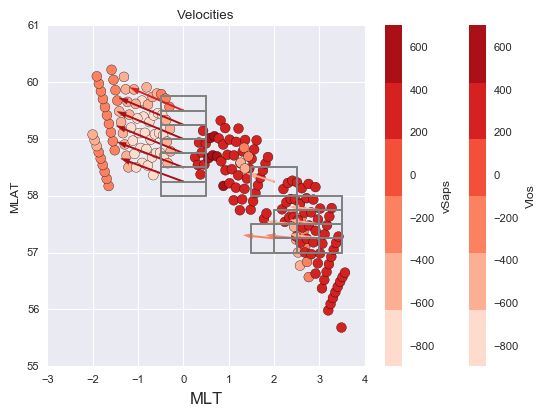

In [66]:

#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
plotMLTs = velAnlysDF['grid_MLT'].unique().tolist()
plotMLATs = velAnlysDF['grid_MLAT'].unique().tolist()

velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (fitResultsDF["vSaps"].max() + 100.)*100/100 - (fitResultsDF["vSaps"].max() + 100.)%100
velAnlysDF.plot( kind='scatter',
              x='normMLT_x',
              y='MLAT',
              c='Vlos',
              s=50., cmap=seaMap, ax=ax)

fitResultsDF.plot( kind='scatter',
              x='grid_normMLT',
              y='grid_MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
ax.set_ylim( [int(round(velAnlysDF['grid_MLAT'].min()))-1, \
              int(round(velAnlysDF['grid_MLAT'].max()))+1] )
ax.set_xlim( [int(round(velAnlysDF['grid_MLT'].min()))-1, \
              int(round(velAnlysDF['grid_MLT'].max()))] )

plotMLTends = fitResultsDF['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF['grid_MLT'].tolist()
plotMLATbegins = fitResultsDF['grid_MLAT'].tolist()
plotVelMagns = fitResultsDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.1, head_length=0.2, fc=currCol, ec=currCol)
# Overlay the cells where good fits came from
for frRows in fitResultsDF.iterrows():
    ax.plot( [ frRows[1]["grid_MLT_Begin"], frRows[1]["grid_MLT_Begin"] ], \
            [ frRows[1]["grid_MLAT_Begin"], frRows[1]["grid_MLAT_End"] ], '0.5' )
    ax.plot( [ frRows[1]["grid_MLT_Begin"], frRows[1]["grid_MLT_End"] ], \
            [ frRows[1]["grid_MLAT_Begin"], frRows[1]["grid_MLAT_Begin"] ], '0.5' )
    
    ax.plot( [ frRows[1]["grid_MLT_Begin"], frRows[1]["grid_MLT_End"] ], \
            [ frRows[1]["grid_MLAT_End"], frRows[1]["grid_MLAT_End"] ], '0.5' )
    ax.plot( [ frRows[1]["grid_MLT_End"], frRows[1]["grid_MLT_End"] ], \
            [ frRows[1]["grid_MLAT_Begin"], frRows[1]["grid_MLAT_End"] ], '0.5' )
    
ax.get_figure().savefig("../figs/fitVels-smallgrid.pdf",bbox_inches='tight')
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####

Vmax---> 1356.77968508 +/- 37.3879645242
delTheta---> -17.8349388465 +/- 0.712905789061


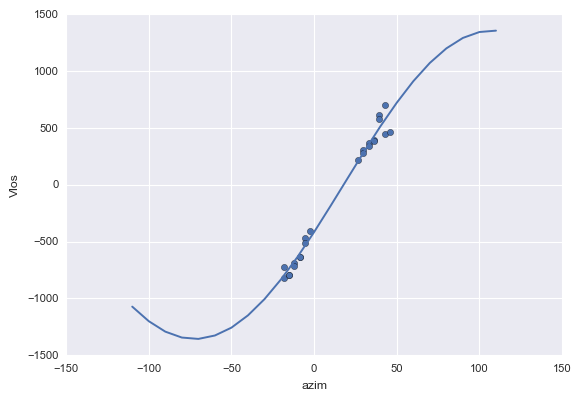

In [15]:
testMlt = -0.5
testMlat = 58.5
testFittingDF = velAnlysDF[ ( (velAnlysDF["grid_MLT"] >= testMlt) & (velAnlysDF["grid_MLT"] <= testMlt+1.) &\
                                (velAnlysDF["grid_MLAT"] >= testMlat) & (velAnlysDF["grid_MLAT"] <= testMlat+0.5) ) ].\
                    reset_index(drop=True)
# print testFittingDF.head(20)
#### Plot the fitting ####
#### Plot the fitting ####
#### Plot the fitting ####
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

initGuess = ( 1000., 10. ) # radians
popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                        testFittingDF['azim'].T,\
                        testFittingDF['Vlos'].T,
                       p0=initGuess)
print "Vmax--->", popt[0],"+/-", pcov[0,0]**0.5
print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5

# plot the model against the given data
def model_func(theta, Vmax=popt[0], delTheta=popt[1]):
    Vlos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
#     print "Vlos, theta", Vlos, theta
    return Vlos
thetaArr = range(-110, 120, 10)
vLosArr = [ round( model_func(t) ) for t in thetaArr ]
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
testFittingDF.plot( x="azim", y="Vlos", kind="scatter", ax=ax )
ax.plot( thetaArr, vLosArr )
#### Plot the fitting ####
#### Plot the fitting ####
#### Plot the fitting ####

a is false
